## E09 - movie review sentiment analysis

In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [2]:
# 결측치 확인
print(train_data.isnull().sum(), end='\n\n')
print(test_data.isnull().sum())

id          0
document    5
label       0
dtype: int64

id          0
document    3
label       0
dtype: int64


In [3]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    # 중복 데이터 제거하기
    train_data.drop_duplicates(subset=['document'], inplace=True)
    test_data.drop_duplicates(subset=['document'], inplace=True)
    
    # 결측치 제거하기
    train_data.dropna(how='any', inplace=True)
    test_data.dropna(how='any', inplace=True)
    
    X_train = []
    for sentence in train_data['document']:
        # 토큰화하기
        temp_data = tokenizer.morphs(sentence)
        # 불용어 제거하기
        temp_data = [word for word in temp_data if not word in stopwords]
        X_train.append(temp_data)
        
    X_test = []
    for sentence in test_data['document']:
        #토큰화하기
        temp_data = tokenizer.morphs(sentence)
        #불용어 제거하기
        temp_data = [word for word in temp_data if not word in stopwords]
        X_test.append(temp_data)
        
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4) # most_common(n): 최빈값 n개 반환 [(1, x), (2, y), ... , (n, xx)]
    # 데이터셋에서 만든 사전
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
    
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
   
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)
print("훈련 샘플 개수: {}, 테스트 개수: {}".format(len(X_train), len(X_test)))

훈련 샘플 개수: 146182, 테스트 개수: 49157


In [4]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [5]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [6]:
print(X_train[0]) # 1번째 리뷰
print(y_train[0]) # 1번째 리뷰 라벨

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
0


In [7]:
# 문장 최대 길이 확인하기(maxlen)

total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.969376315021577
문장길이 최대 :  116
문장길이 표준편차 :  12.843535456326455
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [8]:
# 데이터셋의 문장 길이 맞추기
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


In [9]:
# RNN모델을 사용

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

model_lstm = keras.Sequential()
model_lstm.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_lstm.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경가능)
model_lstm.add(keras.layers.Dense(8, activation='relu'))
model_lstm.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 300)         3000000   
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 9888      
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 3,009,969
Trainable params: 3,009,969
Non-trainable params: 0
_________________________________________________________________


In [10]:
# CNN모델을 사용

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

model_cnn = keras.Sequential()
model_cnn.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_cnn.add(keras.layers.Conv1D(16, 7, activation='relu'))
model_cnn.add(keras.layers.MaxPooling1D(5))
model_cnn.add(keras.layers.Conv1D(16, 7, activation='relu'))
model_cnn.add(keras.layers.GlobalMaxPooling1D())
model_cnn.add(keras.layers.Dense(8, activation='relu'))
model_cnn.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 300)         3000000   
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          33616     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [11]:
# pooling만 사용

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

model_pool = keras.Sequential()
model_pool.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_pool.add(keras.layers.GlobalMaxPooling1D())
model_pool.add(keras.layers.Dense(8, activation='relu'))
model_pool.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_pool.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 300)         3000000   
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 300)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 2408      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 3,002,417
Trainable params: 3,002,417
Non-trainable params: 0
_________________________________________________________________


In [15]:
# validation set 10000건 분리
X_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지
partial_X_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


In [16]:
# 모델 학습하기
model_lstm.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10

history_lstm = model_lstm.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
266/266 [==============================] - 8s 29ms/step - loss: 0.4451 - accuracy: 0.8112 - val_loss: 0.4401 - val_accuracy: 0.8142
Epoch 2/10
266/266 [==============================] - 8s 28ms/step - loss: 0.4111 - accuracy: 0.8267 - val_loss: 0.4403 - val_accuracy: 0.8138
Epoch 3/10
266/266 [==============================] - 8s 30ms/step - loss: 0.4067 - accuracy: 0.8295 - val_loss: 0.4228 - val_accuracy: 0.8261
Epoch 4/10
266/266 [==============================] - 8s 30ms/step - loss: 0.3623 - accuracy: 0.8507 - val_loss: 0.3651 - val_accuracy: 0.8466
Epoch 5/10
266/266 [==============================] - 8s 29ms/step - loss: 0.3167 - accuracy: 0.8701 - val_loss: 0.3552 - val_accuracy: 0.8473
Epoch 6/10
266/266 [==============================] - 8s 28ms/step - loss: 0.2962 - accuracy: 0.8801 - val_loss: 0.3510 - val_accuracy: 0.8512
Epoch 7/10
266/266 [==============================] - 8s 28ms/step - loss: 0.2819 - accuracy: 0.8865 - val_loss: 0.3574 - val_accuracy: 0.8525

In [17]:
results = model_lstm.evaluate(X_test, y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3900 - accuracy: 0.8424
[0.3900001645088196, 0.8423622250556946]


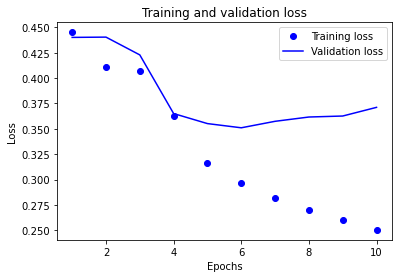

In [18]:
# epoch과정에서 history확인
history_dict = history_lstm.history
# dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

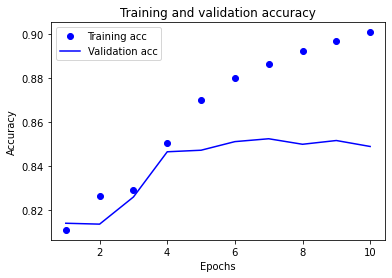

In [19]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [20]:
# model의 첫 번째 레이어인 Embedding, 학습된 워드 벡터가 존재할 것

embedding_layer = model_lstm.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 300)


In [21]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model_lstm.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['재미']
vector

array([-3.15715037e-02, -2.65166699e-03, -6.10907674e-02, -3.00152991e-02,
       -3.99593078e-03, -6.51471540e-02,  5.54017462e-02, -1.19882859e-01,
       -4.89712134e-02, -1.37408629e-01, -4.35900223e-03, -1.27347782e-01,
        1.05225734e-01,  4.78416448e-03, -1.56020587e-02, -9.73325968e-02,
       -1.50511369e-01, -5.72995842e-02, -8.40248540e-02,  3.38682607e-02,
       -1.32614151e-01, -1.97020825e-02,  4.70545376e-03, -1.04150191e-01,
        8.07009730e-03,  6.08066730e-02, -3.77898407e-03, -4.72283177e-02,
        1.62800565e-01,  7.42023811e-02,  9.44733471e-02,  2.54257061e-02,
        9.05278772e-02, -2.99590863e-02,  7.58092254e-02, -1.53170332e-01,
        1.06197633e-01, -6.97058737e-02, -2.71260384e-02,  6.28594086e-02,
       -9.52074211e-03,  1.67123318e-01,  7.81201273e-02, -2.62347553e-02,
        2.97509972e-02,  4.35985439e-02, -6.57257885e-02, -1.45420328e-01,
        1.04411826e-01,  1.63048193e-01,  1.26023412e-01, -1.61760170e-02,
       -6.34671226e-02,  

In [22]:
# 학습된 워드벡터로 임의의 단어와 가장 유사한 단어와 그 유사도를 확인해보는 방법

word_vectors.similar_by_word('대박')

[('재밌', 0.9128355979919434),
 ('순수', 0.9124869108200073),
 ('명장면', 0.8997275829315186),
 ('최고', 0.8969001770019531),
 ('그려냈', 0.8865731358528137),
 ('아련', 0.885982871055603),
 ('떠오르', 0.8824371099472046),
 ('눈물', 0.8781924843788147),
 ('본방', 0.8778918385505676),
 ('~^^', 0.8775900602340698)]

In [23]:
# 모델 학습하기
# validation set 10000건 분리
X_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지
partial_X_train = X_train[10000:]  
partial_y_train = y_train[10000:]

model_cnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10

history_cnn = model_cnn.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
266/266 [==============================] - 16s 62ms/step - loss: 0.4226 - accuracy: 0.8050 - val_loss: 0.3348 - val_accuracy: 0.8524
Epoch 2/10
266/266 [==============================] - 8s 28ms/step - loss: 0.2992 - accuracy: 0.8750 - val_loss: 0.3282 - val_accuracy: 0.8552
Epoch 3/10
266/266 [==============================] - 8s 28ms/step - loss: 0.2402 - accuracy: 0.9046 - val_loss: 0.3358 - val_accuracy: 0.8591
Epoch 4/10
266/266 [==============================] - 7s 28ms/step - loss: 0.1719 - accuracy: 0.9368 - val_loss: 0.3739 - val_accuracy: 0.8544
Epoch 5/10
266/266 [==============================] - 8s 28ms/step - loss: 0.1128 - accuracy: 0.9607 - val_loss: 0.4500 - val_accuracy: 0.8481
Epoch 6/10
266/266 [==============================] - 8s 28ms/step - loss: 0.0742 - accuracy: 0.9756 - val_loss: 0.5374 - val_accuracy: 0.8405
Epoch 7/10
266/266 [==============================] - 8s 28ms/step - loss: 0.0538 - accuracy: 0.9825 - val_loss: 0.5818 - val_accuracy: 0.844

In [24]:
results = model_cnn.evaluate(X_test, y_test, verbose=2)

print(results)

1537/1537 - 5s - loss: 0.8158 - accuracy: 0.8330
[0.8157628178596497, 0.8330451250076294]


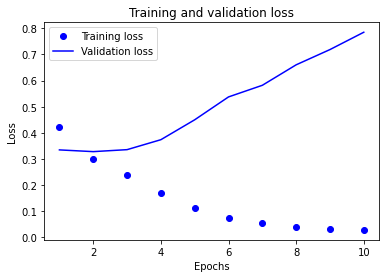

In [25]:
# epoch과정에서 history확인
history_dict = history_cnn.history
# dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

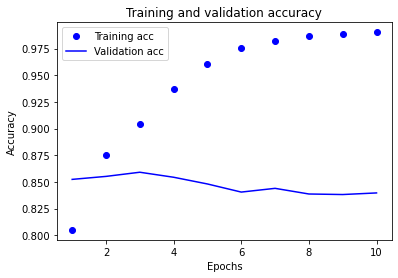

In [26]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [27]:
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

vectors = model_cnn.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['재미']
vector

array([-0.0821739 ,  0.04300399, -0.11097004,  0.00659796,  0.08890323,
        0.02871467, -0.08079505,  0.00535003, -0.01463132,  0.07062499,
        0.07473744,  0.10034133,  0.06756829,  0.01474626, -0.04241185,
        0.06415278,  0.00930088, -0.0267518 , -0.02591516, -0.07290963,
        0.00458693, -0.04069524,  0.16305837,  0.0665781 , -0.11032909,
        0.06689744, -0.01135381, -0.03581867, -0.01368111, -0.09372195,
        0.03819086, -0.08988541,  0.04648191, -0.03871176, -0.00823888,
       -0.05285626, -0.03659931, -0.01065717, -0.17604388, -0.12371458,
       -0.08477478,  0.02929431, -0.01012116, -0.01083597, -0.18667616,
        0.05023036, -0.00937275,  0.01451896,  0.07853559,  0.0476809 ,
       -0.05014046, -0.05289481, -0.03969235,  0.02639146, -0.0144202 ,
        0.03465116, -0.10742293,  0.01085188, -0.01898975,  0.05342243,
        0.10324337,  0.12647843, -0.03530284,  0.02495007,  0.03477848,
        0.09713364,  0.10083295,  0.056383  , -0.01958958, -0.04

In [28]:
# 학습된 워드벡터로 임의의 단어와 가장 유사한 단어와 그 유사도를 확인해보는 방법

word_vectors.similar_by_word('대박')

[('늠', 0.6478805541992188),
 ('~~^^', 0.6446303129196167),
 ('수작', 0.6438689231872559),
 ('웰메이드', 0.6426193714141846),
 ('쏠쏠', 0.6403714418411255),
 ('^.^', 0.6356489658355713),
 ('깨알', 0.6352609395980835),
 ('이루어질', 0.6338224411010742),
 ('슬퍼요', 0.6317129135131836),
 ('였음을', 0.6313894987106323)]

In [29]:
# 모델 학습하기
# validation set 10000건 분리
X_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지
partial_X_train = X_train[10000:]  
partial_y_train = y_train[10000:]

model_pool.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10

history_pool = model_pool.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
266/266 [==============================] - 7s 27ms/step - loss: 0.4454 - accuracy: 0.8128 - val_loss: 0.3367 - val_accuracy: 0.8525
Epoch 2/10
266/266 [==============================] - 7s 27ms/step - loss: 0.3042 - accuracy: 0.8718 - val_loss: 0.3290 - val_accuracy: 0.8553
Epoch 3/10
266/266 [==============================] - 7s 27ms/step - loss: 0.2568 - accuracy: 0.8967 - val_loss: 0.3375 - val_accuracy: 0.8578
Epoch 4/10
266/266 [==============================] - 7s 27ms/step - loss: 0.2136 - accuracy: 0.9178 - val_loss: 0.3544 - val_accuracy: 0.8556
Epoch 5/10
266/266 [==============================] - 7s 27ms/step - loss: 0.1677 - accuracy: 0.9397 - val_loss: 0.3821 - val_accuracy: 0.8509
Epoch 6/10
266/266 [==============================] - 7s 27ms/step - loss: 0.1222 - accuracy: 0.9608 - val_loss: 0.4143 - val_accuracy: 0.8489
Epoch 7/10
266/266 [==============================] - 7s 27ms/step - loss: 0.0830 - accuracy: 0.9764 - val_loss: 0.4587 - val_accuracy: 0.8469

In [31]:
results = model_pool.evaluate(X_test, y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.5889 - accuracy: 0.8406
[0.588854193687439, 0.8406127095222473]


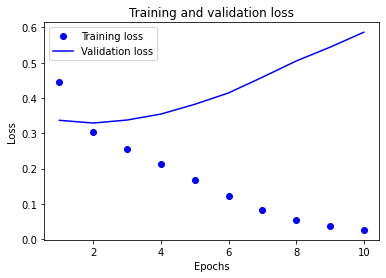

In [32]:
# epoch과정에서 history확인
history_dict = history_pool.history
# dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

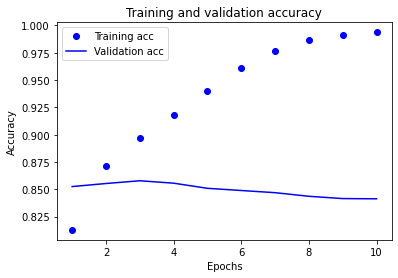

In [33]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [34]:
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

vectors = model_pool.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['재미']
vector

array([ 0.07780799, -0.09337287,  0.0652566 , -0.10467735, -0.0601169 ,
        0.01831111,  0.07467451, -0.10504161, -0.05181692, -0.10768289,
       -0.07231932, -0.1128674 , -0.07315604,  0.01664053, -0.06539871,
        0.12941441, -0.0074065 , -0.05772055, -0.04978089, -0.07883624,
       -0.04547619, -0.00465728, -0.05539033,  0.10115676, -0.05124734,
        0.02720513, -0.09321904,  0.11246976, -0.14445524, -0.09671562,
        0.02745089,  0.16495267, -0.03041976, -0.02937029, -0.01953994,
       -0.09004808, -0.02147289, -0.14895692, -0.1307955 , -0.11134616,
       -0.10093413, -0.09913037,  0.09186705, -0.03351152, -0.09161551,
       -0.09714064, -0.0832047 , -0.06846518, -0.20874448,  0.1309016 ,
        0.02196555,  0.14847422, -0.10957895, -0.10158681, -0.02331327,
       -0.05551369, -0.01588032, -0.06505791,  0.00648833,  0.08274308,
       -0.08807572,  0.10836193,  0.02231841, -0.03703573, -0.05195492,
        0.15586112, -0.0311331 , -0.11109555, -0.07817557,  0.01

In [35]:
# 학습된 워드벡터로 임의의 단어와 가장 유사한 단어와 그 유사도를 확인해보는 방법

word_vectors.similar_by_word('대박')

[('세요', 0.24426192045211792),
 ('여운', 0.24257305264472961),
 ('오랜만', 0.23129713535308838),
 ('ㅜㅜ', 0.22721442580223083),
 ('두', 0.223899245262146),
 ('보드', 0.21860213577747345),
 ('배우', 0.21736766397953033),
 ('분위기', 0.21735350787639618),
 ('없이', 0.215876966714859),
 ('해설', 0.21478070318698883)]

RNN 모델  
loss: 0.3900 - accuracy: 0.8424  
학습된 워드 벡터로 유사한 단어를 꽤 잘 찾아낸다.   

CNN 모델   
loss: 0.8158 - accuracy: 0.8330  
RNN모델보다 유사도가 조금 떨어진다.

pool만 사용  
loss: 0.5889 - accuracy: 0.8406   
유사도 확인에서 너무 낮다. 이상하다. 데이터 초기화 했는데...   

In [68]:
# 한국어 word2vec 이용하기

import gensim
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if word2vec.wv.__contains__(index_to_word[i]):
        embedding_matrix[i] = word2vec.wv.__getitem__(index_to_word[i])

In [69]:
# 모델 구성
from keras.initializers import Constant
model_koR = keras.Sequential()
model_koR.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model_koR.add(keras.layers.Conv1D(16, 7, activation='relu'))
model_koR.add(keras.layers.MaxPooling1D(5))
model_koR.add(keras.layers.Conv1D(16, 7, activation='relu'))
model_koR.add(keras.layers.GlobalMaxPooling1D())
model_koR.add(keras.layers.Dense(8, activation='relu'))
model_koR.add(keras.layers.Dense(1, activation='sigmoid')) 

model_koR.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 35, 16)            22416     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 7, 16)             0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 16)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                

In [70]:
# 학습의 진행
# validation set 10000건 분리
X_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지
partial_X_train = X_train[10000:]  
partial_y_train = y_train[10000:]

model_koR.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  

history_koR = model_koR.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
2128/2128 [==============================] - 36s 17ms/step - loss: 0.4739 - accuracy: 0.7525 - val_loss: 0.3565 - val_accuracy: 0.8434
Epoch 2/10
2128/2128 [==============================] - 28s 13ms/step - loss: 0.3291 - accuracy: 0.8583 - val_loss: 0.3347 - val_accuracy: 0.8525
Epoch 3/10
2128/2128 [==============================] - 28s 13ms/step - loss: 0.2925 - accuracy: 0.8767 - val_loss: 0.3278 - val_accuracy: 0.8550
Epoch 4/10
2128/2128 [==============================] - 28s 13ms/step - loss: 0.2648 - accuracy: 0.8905 - val_loss: 0.3372 - val_accuracy: 0.8528
Epoch 5/10
2128/2128 [==============================] - 28s 13ms/step - loss: 0.2374 - accuracy: 0.9031 - val_loss: 0.3610 - val_accuracy: 0.8527
Epoch 6/10
2128/2128 [==============================] - 28s 13ms/step - loss: 0.2106 - accuracy: 0.9155 - val_loss: 0.3929 - val_accuracy: 0.8489
Epoch 7/10
2128/2128 [==============================] - 28s 13ms/step - loss: 0.1833 - accuracy: 0.9275 - val_loss: 0.4114 -

In [71]:
results = model_koR.evaluate(X_test, y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.5923 - accuracy: 0.8397
[0.5922560095787048, 0.8397380113601685]


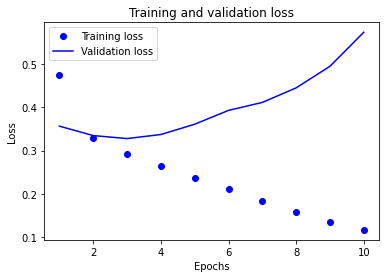

In [72]:
# epoch과정에서 history확인
history_dict = history_koR.history
# dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

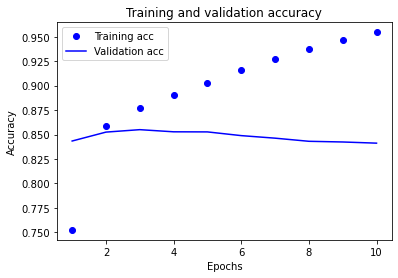

In [73]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [74]:
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

vectors = model_koR.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['재미']
vector

array([ 0.00577776, -0.65306437,  0.371689  , -1.2402343 , -1.1814426 ,
       -0.64402634, -0.19001149,  0.51666677,  0.05042283,  0.36142746,
       -0.65249527,  0.33996958,  0.8143649 ,  1.1185719 , -0.95410955,
        0.53508294, -0.18898784,  1.3541889 ,  0.68612224,  0.11906191,
       -0.38935715, -0.45948127,  0.2857217 ,  0.3830475 ,  0.6272227 ,
        0.2604721 ,  0.5397699 ,  0.64865553,  0.32912078, -0.56621647,
       -1.3851476 , -0.36833906, -0.7620392 ,  0.36746135,  0.75635237,
       -1.3165169 ,  0.42561075,  0.8851073 ,  0.8772501 ,  0.81199276,
        1.3386259 , -0.45939845, -0.75283307, -0.4392536 , -0.099571  ,
       -0.45755756,  1.1690022 ,  0.19904014, -0.84947324, -0.63717335,
        0.23029071, -0.62508094, -0.58517396,  0.14374888, -1.4901227 ,
        0.34760362,  0.88721526, -0.34121463,  0.08968925, -0.57654834,
        0.5395483 , -0.46896523, -0.9010956 ,  0.66406775,  0.07793205,
       -1.0567714 ,  0.7286318 ,  0.8056225 , -0.01768406,  0.95

In [75]:
# 학습된 워드벡터로 임의의 단어와 가장 유사한 단어와 그 유사도를 확인해보는 방법

word_vectors.similar_by_word('대박')

[('단연', 0.6689707040786743),
 ('미생', 0.6627129316329956),
 ('악평', 0.6589504480361938),
 ('코스모스', 0.6483374834060669),
 ('드라마틱', 0.6266109943389893),
 ('오래도록', 0.6254310607910156),
 ('해학', 0.6162319183349609),
 ('씨네', 0.6131155490875244),
 ('후편', 0.6120657920837402),
 ('냉혹', 0.6090768575668335)]

한국어 Word2Vec 임베딩을 활용했지만 마의 85%를 넘지 못하였으며  
유사도도 RNN보다 낮았다.   
네 모델 모두 정확도가 85%까지 빠르게 도달하였으며 거의 일정하였다.   
batch_size 조정: 유사도 조금씩 높아짐.   